In [4]:
import dart_fss as dart

# Open DART API KEY 설정
api_key='	c7e2c241d6af4487d166c5fafc045ad0448e015e'
dart.set_api_key(api_key=api_key)

# DART 에 공시된 회사 리스트 불러오기
corp_list = dart.get_corp_list()

# 삼성전자 검색
samsung = corp_list.find_by_corp_name('SK텔레콤', exactly=True)[0]

# 2012년부터 연간 연결재무제표 불러오기
fs = samsung.extract_fs(bgn_de='20240101')

# 재무제표 검색 결과를 엑셀파일로 저장 ( 기본저장위치: 실행폴더/fsdata )
fs.save()

Annual reports:   0%|          | 0/2 [00:00<?, ?report/s]

'/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00159023_annual.xlsx'

In [8]:
from dart_fss.filings import get_corp_code

# 회사명으로 corp_code 찾기
corp_code = get_corp_code('삼성전자')

# corp 객체 수동 생성
samsung = Corp(corp_code=corp_code, corp_name='삼성전자', stock_code='005930')

# 연간 재무제표 추출
fs = samsung.extract_fs(bgn_de='20240101')
fs.save()

ImportError: cannot import name 'get_corp_code' from 'dart_fss.filings' (/opt/homebrew/lib/python3.10/site-packages/dart_fss/filings/__init__.py)

In [20]:
import dart_fss

# 캐시 삭제
dart_fss.utils.delete_cache()

# 다시 불러오기
corp_list = dart_fss.get_corp_list()

AttributeError: module 'dart_fss.utils' has no attribute 'delete_cache'

In [17]:
import pandas as pd

# 엑셀 파일 경로
file_path = '/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00126380_annual.xlsx'

# pandas로 엑셀 불러오기
df = pd.read_excel(file_path, engine='openpyxl')

# 데이터 확인 (상위 5개 행 출력)
print(df)

  Unnamed: 0      info
0  corp_code  00126380
1     bgn_de  20240101
2     end_de       NaN
3   separate     False
4  report_tp    annual
5       lang        ko
6  separator      True


In [5]:
import pandas as pd

# 파일 경로 지정
file_path = '/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00126380_annual.xlsx'

# 1) 메타데이터 시트(기본적으로 첫 번째 시트)가 바로 위와 같은 형태라면, 우선 불러오기
meta = pd.read_excel(file_path, engine='openpyxl')

# 2) "Unnamed: 0"를 인덱스로 설정하고, “info” 열을 하나의 Series로 변환
meta = meta.set_index('Unnamed: 0')['info']

# 결과 확인: 각 항목이 index=상태, 값=실제 info로 표시됩니다
print(meta)

Unnamed: 0
corp_code    00126380
bgn_de       20240101
end_de            NaN
separate        False
report_tp      annual
lang               ko
separator        True
Name: info, dtype: object


In [ ]:
import pandas as pd
import dart_fss as dart
from datetime import datetime

# 1. DART API 키 설정
dart.set_api_key("c7e2c241d6af4487d166c5fafc045ad0448e015e")

# 2. 기업 리스트
corp_names = ["삼성전자", "LG전자", "SK텔레콤", "현대자동차", "LG화학", "포스코", "KB금융"]

# 3. 결과 저장 리스트
results = []

# 4. 회사 리스트 호출
corp_list = dart.get_corp_list()

# 5. 재무제표 추출 함수 정의
def fs_extract(corp_n):
    try:
        fs = corp_n.extract_fs(bgn_de='20230101')
        separate = False
    except:
        fs = corp_n.extract_fs(bgn_de='20230101', separate=True)
        separate = True
    return fs, separate

# 6. 기업별 루프
for name in corp_names:
    try:
        corp = corp_list.find_by_corp_name(name, exactly=True)[0]

        # 재무제표 추출
        fs, separate = fs_extract(corp)
        df_fs = fs.fs  # get_fs_table() 사용 불가 버전 고려

        df_2023_fs = df_fs.xs(("2023", "annual"), level=("year", "fs_type"))
        df_2022_fs = df_fs.xs(("2022", "annual"), level=("year", "fs_type"))

        # 현금흐름표 추출
        cf = corp.extract_cf(bgn_de="20230101", report_tp="annual")
        df_cf = cf.cf
        df_2023_cf = df_cf.xs(("2023", "annual"), level=("year", "fs_type"))

        # 재무 지표 계산
        total_liabilities = df_2023_fs.loc["TotalLiabilities", "value"]
        total_equity = df_2023_fs.loc["TotalEquity", "value"]
        debt_ratio = total_liabilities / total_equity * 100

        operating_income = df_2023_fs.loc["OperatingIncome", "value"]
        interest_expense = (
            df_2023_fs.loc["InterestExpense", "value"]
            if "InterestExpense" in df_2023_fs.index
            else df_2023_fs.loc.get("FinancialCost", 0)
        )
        int_cover_ratio = operating_income / interest_expense if interest_expense != 0 else None

        current_assets = df_2023_fs.loc["CurrentAssets", "value"]
        current_liabilities = df_2023_fs.loc["CurrentLiabilities", "value"]
        current_ratio = current_assets / current_liabilities * 100

        net_income = df_2023_fs.loc["NetIncome", "value"]
        roe = net_income / total_equity * 100

        net_sales_2023 = df_2023_fs.loc["NetSales", "value"]
        op_margin = operating_income / net_sales_2023 * 100

        net_sales_2022 = df_2022_fs.loc["NetSales", "value"]
        rev_growth = (net_sales_2023 - net_sales_2022) / net_sales_2022 * 100

        operating_cf = df_2023_cf.loc["OperatingCashFlow", "value"]
        capex = (
            df_2023_cf.loc["PurchaseOfPropertyPlantAndEquipment", "value"]
            if "PurchaseOfPropertyPlantAndEquipment" in df_2023_cf.index
            else df_2023_cf.loc.get("InvestmentInPropertyPlantAndEquipment", 0)
        )
        fcf = operating_cf - capex

        total_assets = df_2023_fs.loc["TotalAssets", "value"]
        asset_turnover = net_sales_2023 / total_assets

        depreciation = df_2023_fs.loc.get("Depreciation", 0)
        amortization = df_2023_fs.loc.get("Amortization", 0)
        ebitda = operating_income + depreciation + amortization

        results.append({
            "corp_name": name,
            "debt_ratio (%)": debt_ratio,
            "interest_coverage": int_cover_ratio,
            "current_ratio (%)": current_ratio,
            "ROE (%)": roe,
            "Operating_margin (%)": op_margin,
            "Revenue_growth (%)": rev_growth,
            "Free_cash_flow": fcf,
            "Asset_turnover": asset_turnover,
            "EBITDA": ebitda
        })

    except Exception as e:
        print(f"[Error] {name}: {e}")
        results.append({
            "corp_name": name,
            "debt_ratio (%)": None,
            "interest_coverage": None,
            "current_ratio (%)": None,
            "ROE (%)": None,
            "Operating_margin (%)": None,
            "Revenue_growth (%)": None,
            "Free_cash_flow": None,
            "Asset_turnover": None,
            "EBITDA": None
        })

# 7. 결과 출력
df_results = pd.DataFrame(results)
print(df_results)

Annual reports:   0%|          | 0/3 [00:00<?, ?report/s]

[Error] 삼성전자: 'FinancialStatement' object has no attribute 'fs'


Annual reports:   0%|          | 0/3 [00:00<?, ?report/s]

[Error] LG전자: 'FinancialStatement' object has no attribute 'fs'


Annual reports:   0%|          | 0/3 [00:00<?, ?report/s]

[Error] SK텔레콤: 'FinancialStatement' object has no attribute 'fs'


Annual reports:   0%|          | 0/4 [00:00<?, ?report/s]

⠇ XBRL Loading                        

Annual reports:   0%|          | 0/4 [00:00<?, ?report/s]

⠹ XBRL Loading                        

In [2]:
import pandas as pd

# --------------------------------------------
# 1) 로컬에 저장된 재무제표 엑셀 파일 경로 지정
#    (fs.save()로 저장된 파일 경로를 정확히 입력하세요)
# --------------------------------------------
fs_file = "/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00126380_annual.xlsx"
# 필요하다면 현금흐름표도 저장해두셨다면 해당 경로를 지정하세요
# cf_file = "/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00126380_cashflow.xlsx"

# --------------------------------------------
# 2) pandas로 엑셀 불러오기
#    - DART API 호출 없이, 이미 저장된 재무제표만 사용해서 지표를 계산
# --------------------------------------------
df_fs = pd.read_excel(fs_file, sheet_name=0, engine="openpyxl")

# --------------------------------------------
# 3) 불러온 DataFrame 구조 확인
#    (예시로 상위 몇 개 열과 인덱스 레이아웃을 가정)
# --------------------------------------------
# df_fs의 대표적인 컬럼 구성이 아래와 같다고 가정합니다:
#   ["year", "fs_type", "account_id", "account_nm", "value", ...]
#
# 만약 실제 컬럼명이 다르다면, 다음 코드를 실행해 컬럼명을 확인하세요:
# print(df_fs.columns)
# print(df_fs.head())

# --------------------------------------------
# 4) MultiIndex (year, fs_type) 기반으로 인덱스 설정
# --------------------------------------------
# 엑셀에 "year"와 "fs_type" 열이 있다면 이를 인덱스로 삼습니다.
# 만약 컬럼명이 다르면, 실제 컬럼명에 맞춰 "year"→"보고년도", "fs_type"→"재무제표구분" 등으로 수정하세요.
df_fs = df_fs.set_index(["year", "fs_type", "account_nm"])

# --------------------------------------------
# 5) 2023년 연간 데이터만 추출
# --------------------------------------------
df_2023_fs = df_fs.xs(("2023", "annual"), level=("year", "fs_type"))
df_2022_fs = df_fs.xs(("2022", "annual"), level=("year", "fs_type"))

# --------------------------------------------
# 6) 지표별 값 추출 및 계산
# --------------------------------------------
# (1) 부채비율 (Debt to Equity Ratio)
total_liabilities = df_2023_fs.loc["TotalLiabilities", "value"]
total_equity      = df_2023_fs.loc["TotalEquity", "value"]
debt_ratio        = total_liabilities / total_equity * 100

# (2) 이자보상배율 (Interest Coverage Ratio)
operating_income = df_2023_fs.loc["OperatingIncome", "value"]
if "InterestExpense" in df_2023_fs.index:
    interest_expense = df_2023_fs.loc["InterestExpense", "value"]
else:
    interest_expense = df_2023_fs.loc["FinancialCost", "value"]
int_cover_ratio = operating_income / interest_expense if interest_expense != 0 else None

# (3) 유동비율 (Current Ratio)
current_assets      = df_2023_fs.loc["CurrentAssets", "value"]
current_liabilities = df_2023_fs.loc["CurrentLiabilities", "value"]
current_ratio       = current_assets / current_liabilities * 100

# (4) ROE (Return on Equity)
net_income = df_2023_fs.loc["NetIncome", "value"]
roe        = net_income / total_equity * 100

# (5) 영업이익률 (Operating Margin)
net_sales_2023 = df_2023_fs.loc["NetSales", "value"]
op_margin      = operating_income / net_sales_2023 * 100

# (6) 매출 성장률 (Revenue Growth Rate)
net_sales_2022 = df_2022_fs.loc["NetSales", "value"]
rev_growth     = (net_sales_2023 - net_sales_2022) / net_sales_2022 * 100

# (7) 자유현금흐름 (Free Cash Flow, FCF)
#    현금흐름표를 따로 저장해두셨다면, 아래처럼 cf_file을 불러와서 동일한 방식으로 추출하세요.
# operating_cf = df_cf_2023.loc["OperatingCashFlow", "value"]
# if "PurchaseOfPropertyPlantAndEquipment" in df_cf_2023.index:
#     capex = df_cf_2023.loc["PurchaseOfPropertyPlantAndEquipment", "value"]
# else:
#     capex = df_cf_2023.loc["InvestmentInPropertyPlantAndEquipment", "value"]
# fcf = operating_cf - capex
# 
# 여기서는 재무제표에 영업현금흐름이 포함되지 않는 경우가 많으므로,
# 이미 별도로 저장된 현금흐름표가 없다면 Free Cash Flow 계산은 생략하거나
# DART API에서 현금흐름을 직접 호출해야 합니다.
fcf = None  # 현금흐름표 파일이 없으면 None 처리

# (8) 총자산회전율 (Asset Turnover Ratio)
total_assets   = df_2023_fs.loc["TotalAssets", "value"]
asset_turnover = net_sales_2023 / total_assets

# (9) EBITDA 계산 (영업이익 + 감가상각 + 무형자산상각)
depreciation = df_2023_fs.loc["Depreciation", "value"]
amortization = df_2023_fs.loc["Amortization", "value"]
ebitda       = operating_income + depreciation + amortization

# --------------------------------------------
# 7) 결과 정리 및 출력
# --------------------------------------------
df_result = pd.DataFrame([{
    "corp_name": "삼성전자",
    "debt_ratio (%)": debt_ratio,
    "interest_coverage": int_cover_ratio,
    "current_ratio (%)": current_ratio,
    "ROE (%)": roe,
    "Operating_margin (%)": op_margin,
    "Revenue_growth (%)": rev_growth,
    "Free_cash_flow": fcf,
    "Asset_turnover": asset_turnover,
    "EBITDA": ebitda
}])

print(df_result)

KeyError: "None of ['year', 'fs_type', 'account_nm'] are in the columns"

In [ ]:
import pandas as pd

# --------------------------------------------
# 1) 로컬에 저장된 재무제표 엑셀 파일 경로 지정
# --------------------------------------------
fs_path1 = "/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00126380_annual.xlsx"
fs_path2 = "/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00159023_annual.xlsx"
fs_path3 = "/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00401731_annual.xlsx"
# --------------------------------------------
# 2) 각 시트별로 데이터프레임 불러오기
# --------------------------------------------
df_bs = pd.read_excel(fs_path, sheet_name="Data_bs", engine="openpyxl")
df_is = pd.read_excel(fs_path, sheet_name="Data_is", engine="openpyxl")
df_cf = pd.read_excel(fs_path, sheet_name="Data_cf", engine="openpyxl")

# --------------------------------------------
# 3) 실제 데이터가 시작되는 3번째 행(인덱스 2)부터 사용하고,
#    concept_id 역할을 하는 두 번째 열을 인덱스로 설정
# --------------------------------------------
concept_col_bs = df_bs.columns[1]
df_bs2 = df_bs.iloc[2:].copy().set_index(concept_col_bs)

concept_col_is = df_is.columns[1]
df_is2 = df_is.iloc[2:].copy().set_index(concept_col_is)

concept_col_cf = df_cf.columns[1]
df_cf2 = df_cf.iloc[2:].copy().set_index(concept_col_cf)

# --------------------------------------------
# 4) 연간 2023년 컬럼 이름
# --------------------------------------------
col_bs = "20231231"
col_is = "20230101-20231231"
col_cf = "20230101-20231231"

# --------------------------------------------
# 헬퍼 함수: 인덱스에 부분 문자열이 포함된 첫 번째 행 값 반환
# --------------------------------------------
def get_value_by_keyword(df, keyword, column):
    matches = [idx for idx in df.index if keyword in idx]
    if matches:
        return df.loc[matches[0], column]
    else:
        return None

# --------------------------------------------
# 5) 재무상태표(Data_bs)에서 필요한 값 추출
# --------------------------------------------
total_assets        = get_value_by_keyword(df_bs2, "ifrs-full_Assets", col_bs)
total_liabilities   = get_value_by_keyword(df_bs2, "ifrs-full_Liabilities", col_bs)
total_equity        = get_value_by_keyword(df_bs2, "ifrs-full_Equity", col_bs)
current_assets      = get_value_by_keyword(df_bs2, "ifrs-full_CurrentAssets", col_bs)
current_liabilities = get_value_by_keyword(df_bs2, "ifrs-full_CurrentLiabilities", col_bs)
depreciation        = get_value_by_keyword(df_bs2, "ifrs-full_Depreciation", col_bs)
amortization        = get_value_by_keyword(df_bs2, "ifrs-full_Amortization", col_bs)

# --------------------------------------------
# 6) 손익계산서(Data_is)에서 필요한 값 추출
# --------------------------------------------
net_sales_2023 = get_value_by_keyword(df_is2, "ifrs-full_Revenue", col_is)
net_sales_2022 = get_value_by_keyword(df_is2, "ifrs-full_Revenue", "20220101-20221231")
operating_income  = get_value_by_keyword(df_is2, "dart_OperatingIncomeLoss", col_is)
net_income        = get_value_by_keyword(df_is2, "ifrs-full_ProfitLossAttributableToOwnersOfParent", col_is)

# --------------------------------------------
# 7) 현금흐름표(Data_cf)에서 필요한 값 추출
# --------------------------------------------
operating_cf  = get_value_by_keyword(df_cf2, "ifrs-full_CashFlowsFromUsedInOperatingActivities", col_cf)
capex         = get_value_by_keyword(df_cf2, "ifrs-full_PurchaseOfPropertyPlantAndEquipmentClassifiedAsInvestingActivities", col_cf)
interest_paid = get_value_by_keyword(df_cf2, "ifrs-full_InterestPaidClassifiedAsOperatingActivities", col_cf)

# --------------------------------------------
# 8) 각종 재무 지표 계산
# --------------------------------------------
# (1) 부채비율 (Debt to Equity Ratio)
debt_ratio = (total_liabilities / total_equity * 100) if total_equity else None

# (2) 이자보상배율 (Interest Coverage Ratio)
int_cover_ratio = (operating_income / abs(interest_paid)) if operating_income and interest_paid else None

# (3) 유동비율 (Current Ratio)
current_ratio = (current_assets / current_liabilities * 100) if current_liabilities else None

# (4) ROE (Return on Equity)
roe = (net_income / total_equity * 100) if total_equity else None

# (5) 영업이익률 (Operating Margin)
op_margin = (operating_income / net_sales_2023 * 100) if net_sales_2023 else None

# (6) 매출 성장률 (Revenue Growth Rate)
rev_growth = ((net_sales_2023 - net_sales_2022) / net_sales_2022 * 100) if net_sales_2022 else None

# (7) 자유현금흐름 (Free Cash Flow, FCF)
fcf = (operating_cf - capex) if operating_cf and capex else None

# (8) 총자산회전율 (Asset Turnover Ratio)
asset_turnover = (net_sales_2023 / total_assets) if total_assets else None

# (9) EBITDA 계산 (영업이익 + 감가상각비 + 무형자산상각비)
ebitda = None
if all(v is not None for v in [operating_income, depreciation, amortization]):
    ebitda = operating_income + depreciation + amortization

# --------------------------------------------
# 9) 결과 정리 및 출력
# --------------------------------------------
df_result = pd.DataFrame([{
    "corp_name":              "삼성전자",
    "debt_ratio (%)":         debt_ratio,
    "interest_coverage":      int_cover_ratio,
    "current_ratio (%)":      current_ratio,
    "ROE (%)":                roe,
    "Operating_margin (%)":   op_margin,
    "Revenue_growth (%)":     rev_growth,
    "Free_cash_flow":         fcf,
    "Asset_turnover":         asset_turnover,
    "EBITDA":                 ebitda
}])

print(df_result)

  corp_name  debt_ratio (%)  interest_coverage  current_ratio (%)  ROE (%)  \
0      삼성전자        0.017454           7.774412         258.766475   4.0974   

   Operating_margin (%)  Revenue_growth (%)   Free_cash_flow  Asset_turnover  \
0              2.536144          -14.325405  101748719000000        0.567958   

  EBITDA  
0   None  


In [4]:
import pandas as pd

# --------------------------------------------
# 1) 기업별 재무제표 엑셀 경로 정의
# --------------------------------------------
corp_file_map = {
    "삼성전자": "/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00126380_annual.xlsx",
    "LG전자":  "/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00159023_annual.xlsx",
    "SK텔레콤": "/Users/parkchangyu/Githubrepo/Creditcard_Segmentation/company_value/fsdata/00401731_annual.xlsx"
}

# --------------------------------------------
# 2) 키워드 기반 값 추출 함수
# --------------------------------------------
def get_value_by_keyword(df, keyword, column):
    matches = [idx for idx in df.index if keyword in str(idx)]
    return df.loc[matches[0], column] if matches else None

# --------------------------------------------
# 3) 지표 추출 함수
# --------------------------------------------
def extract_financial_indicators(corp_name, fs_path):
    try:
        # (1) 각 시트 로딩
        df_bs = pd.read_excel(fs_path, sheet_name="Data_bs", engine="openpyxl")
        df_is = pd.read_excel(fs_path, sheet_name="Data_is", engine="openpyxl")
        df_cf = pd.read_excel(fs_path, sheet_name="Data_cf", engine="openpyxl")

        # (2) 본문 데이터 정리 (index=concept_id 열)
        df_bs2 = df_bs.iloc[2:].copy().set_index(df_bs.columns[1])
        df_is2 = df_is.iloc[2:].copy().set_index(df_is.columns[1])
        df_cf2 = df_cf.iloc[2:].copy().set_index(df_cf.columns[1])

        # (3) 필요한 컬럼 이름 정의
        col_bs = "20231231"
        col_is = "20230101-20231231"
        col_cf = "20230101-20231231"

        # (4) 주요 값 추출
        total_assets        = get_value_by_keyword(df_bs2, "ifrs-full_Assets", col_bs)
        total_liabilities   = get_value_by_keyword(df_bs2, "ifrs-full_Liabilities", col_bs)
        total_equity        = get_value_by_keyword(df_bs2, "ifrs-full_Equity", col_bs)
        current_assets      = get_value_by_keyword(df_bs2, "ifrs-full_CurrentAssets", col_bs)
        current_liabilities = get_value_by_keyword(df_bs2, "ifrs-full_CurrentLiabilities", col_bs)
        depreciation        = get_value_by_keyword(df_bs2, "ifrs-full_Depreciation", col_bs)
        amortization        = get_value_by_keyword(df_bs2, "ifrs-full_Amortization", col_bs)

        net_sales_2023 = get_value_by_keyword(df_is2, "ifrs-full_Revenue", col_is)
        net_sales_2022 = get_value_by_keyword(df_is2, "ifrs-full_Revenue", "20220101-20221231")
        operating_income  = get_value_by_keyword(df_is2, "dart_OperatingIncomeLoss", col_is)
        net_income        = get_value_by_keyword(df_is2, "ifrs-full_ProfitLossAttributableToOwnersOfParent", col_is)

        operating_cf  = get_value_by_keyword(df_cf2, "ifrs-full_CashFlowsFromUsedInOperatingActivities", col_cf)
        capex         = get_value_by_keyword(df_cf2, "ifrs-full_PurchaseOfPropertyPlantAndEquipmentClassifiedAsInvestingActivities", col_cf)
        interest_paid = get_value_by_keyword(df_cf2, "ifrs-full_InterestPaidClassifiedAsOperatingActivities", col_cf)

        # (5) 지표 계산
        debt_ratio = (total_liabilities / total_equity * 100) if total_equity else None
        int_cover_ratio = (operating_income / abs(interest_paid)) if operating_income and interest_paid else None
        current_ratio = (current_assets / current_liabilities * 100) if current_liabilities else None
        roe = (net_income / total_equity * 100) if total_equity else None
        op_margin = (operating_income / net_sales_2023 * 100) if net_sales_2023 else None
        rev_growth = ((net_sales_2023 - net_sales_2022) / net_sales_2022 * 100) if net_sales_2022 else None
        fcf = (operating_cf - capex) if operating_cf and capex else None
        asset_turnover = (net_sales_2023 / total_assets) if total_assets else None
        ebitda = (
            operating_income + depreciation + amortization
            if all(v is not None for v in [operating_income, depreciation, amortization]) else None
        )

        return {
            "corp_name": corp_name,
            "debt_ratio (%)": debt_ratio,
            "interest_coverage": int_cover_ratio,
            "current_ratio (%)": current_ratio,
            "ROE (%)": roe,
            "Operating_margin (%)": op_margin,
            "Revenue_growth (%)": rev_growth,
            "Free_cash_flow": fcf,
            "Asset_turnover": asset_turnover,
            "EBITDA": ebitda
        }

    except Exception as e:
        print(f"[Error] {corp_name}: {e}")
        return {
            "corp_name": corp_name,
            "debt_ratio (%)": None,
            "interest_coverage": None,
            "current_ratio (%)": None,
            "ROE (%)": None,
            "Operating_margin (%)": None,
            "Revenue_growth (%)": None,
            "Free_cash_flow": None,
            "Asset_turnover": None,
            "EBITDA": None
        }

# --------------------------------------------
# 4) 전체 기업 처리 및 결과 통합
# --------------------------------------------
results = []
for corp_name, path in corp_file_map.items():
    result = extract_financial_indicators(corp_name, path)
    results.append(result)

df_result = pd.DataFrame(results)
print(df_result)

  corp_name  debt_ratio (%)  interest_coverage  current_ratio (%)   ROE (%)  \
0      삼성전자        0.017454           7.774412         258.766475  4.097400   
1      LG전자        0.000342           5.134013          94.161007  9.602306   
2     SK텔레콤      186.843207           6.523856         125.582499  3.625278   

   Operating_margin (%)  Revenue_growth (%)   Free_cash_flow  Asset_turnover  \
0              2.536144          -14.325405  101748719000000        0.567958   
1              9.956572            1.754051    1973323000000        0.584627   
2              4.441011           -0.313609    9183480000000        1.365564   

  EBITDA  
0   None  
1   None  
2   None  


In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# --------------------------------------------
# 1) 정규화할 컬럼 리스트 정의
# --------------------------------------------
features = [
    "debt_ratio (%)",
    "interest_coverage",
    "current_ratio (%)",
    "ROE (%)",
    "Operating_margin (%)",
    "Asset_turnover",
    "Revenue_growth (%)"
]

# --------------------------------------------
# 2) MinMaxScaler 객체 생성
# --------------------------------------------
scaler = MinMaxScaler()

# --------------------------------------------
# 3) 정규화 수행
#    - corp_name 등 문자열 컬럼은 제외
#    - NaN이나 None 값이 있으면, 필요하면 fillna 처리 후 스케일링해야 합니다.
# --------------------------------------------
df_scaled = df_result.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

# --------------------------------------------
# 4) 결과 출력
# --------------------------------------------
print(df_scaled)

# --------------------------------------------
# 5) 정규화된 feature들의 평균으로 '기업 성장률' 컬럼 추가
# --------------------------------------------
df_scaled["기업 성장률"] = df_scaled[features].mean(axis=1)

# --------------------------------------------
# 6) 결과 출력
# --------------------------------------------
print(df_scaled)

  corp_name  debt_ratio (%)  interest_coverage  current_ratio (%)   ROE (%)  \
0      삼성전자        0.000092           1.000000            1.00000  0.078989   
1      LG전자        0.000000           0.000000            0.00000  1.000000   
2     SK텔레콤        1.000000           0.526376            0.19089  0.000000   

   Operating_margin (%)  Revenue_growth (%)   Free_cash_flow  Asset_turnover  \
0              0.000000             0.00000  101748719000000        0.000000   
1              1.000000             1.00000    1973323000000        0.020899   
2              0.256706             0.87141    9183480000000        1.000000   

  EBITDA  
0   None  
1   None  
2   None  
  corp_name  debt_ratio (%)  interest_coverage  current_ratio (%)   ROE (%)  \
0      삼성전자        0.000092           1.000000            1.00000  0.078989   
1      LG전자        0.000000           0.000000            0.00000  1.000000   
2     SK텔레콤        1.000000           0.526376            0.19089  0.000000   

 

                Feature  Importance
2     current_ratio (%)    0.193847
6    Revenue_growth (%)    0.181590
0        debt_ratio (%)    0.141176
1     interest_coverage    0.136057
3               ROE (%)    0.123800
4  Operating_margin (%)    0.116121
5        Asset_turnover    0.107409


/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_75106/1500772698.py:34: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_75106/1500772698.py:34: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_75106/1500772698.py:34: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_75106/1500772698.py:34: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fd/p8gl394x5wjgxs6cdb2744br0000gn/T/ipykernel_75106/1500772698.py:34: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/parkchangyu/Library/Python/3.10/lib/python/si

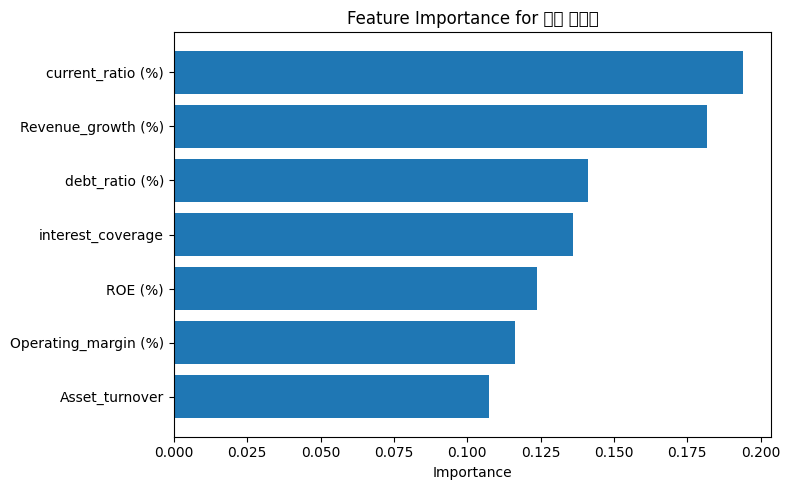

In [6]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# --------------------------------------------
# 1) 피처(X)와 타깃(y) 정의
# --------------------------------------------
X = df_scaled[features]
y = df_scaled["기업 성장률"]

# --------------------------------------------
# 2) 랜덤포레스트 회귀 모델 훈련
# --------------------------------------------
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# --------------------------------------------
# 3) 피처 중요도 추출 및 시각화
# --------------------------------------------
importances = model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# 출력
print(importance_df)

# 시각화
plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance for 기업 성장률")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [7]:
# feature 중요도 → dict 형태로 변환
weights = dict(zip(importance_df["Feature"], importance_df["Importance"]))

# 정규화된 피처에 중요도 가중치를 곱해서 점수 계산
df_scaled["기업성공확률"] = df_scaled[features].apply(
    lambda row: sum(row[feature] * weights[feature] for feature in features), axis=1
)

# 결과 출력
print(df_scaled[["corp_name", "기업 성장률", "기업성공확률"]])

  corp_name    기업 성장률    기업성공확률
0      삼성전자  0.297012  0.339696
1      LG전자  0.431557  0.423755
2     SK텔레콤  0.549340  0.545254
